# Intro
This notebook implements the pipeline we introduced in our project report. It is a two phase program that first identify the masks from the input image and then segments the masks into individual nuclei to the appropriate output format for submission.

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.


# Pipline


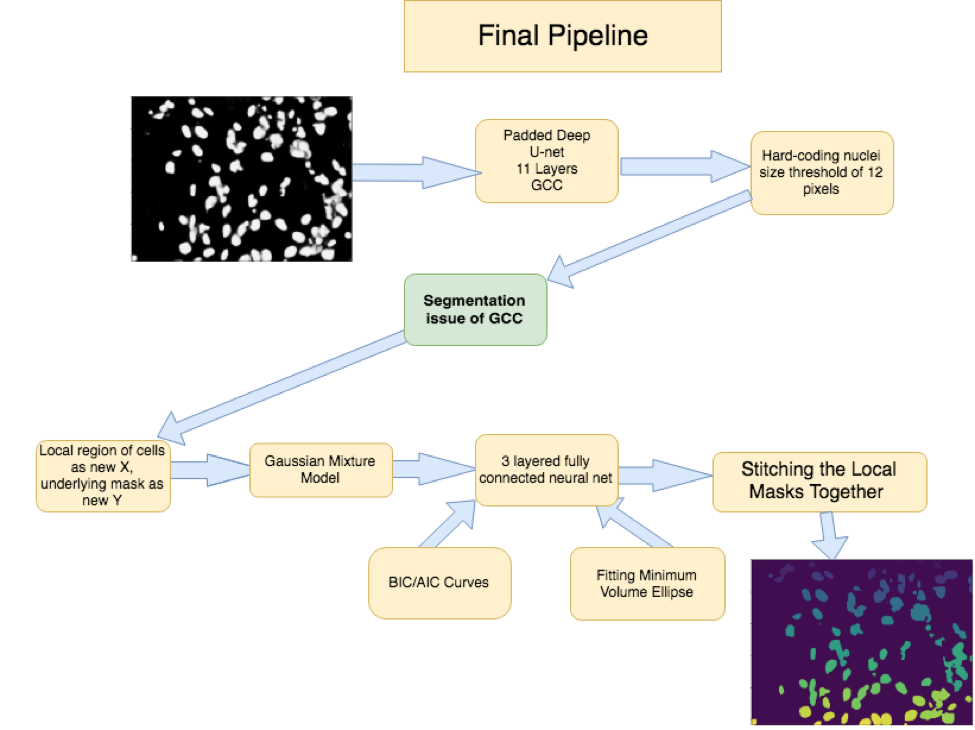

In [2]:

from IPython.display import Image
Image("/Users/haowang/Desktop/Picture1.png")

In [1]:

import os
import sys
import random
import warnings

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, UpSampling2D, Reshape
from keras.layers import Conv2D, MaxPooling2D

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
    
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 3

# TRAIN_PATH = '/home/ubuntu/TermProject/stage1_train/'
# TEST_PATH = '/home/ubuntu/TermProject/stage1_test/'

# TRAIN_PATH = 'C:/Users/Diyahir/Documents/Comp 540/Term Project/Data/stage1_train/'
# TEST_PATH = 'C:/Users/Diyahir/Documents/Comp 540/Term Project/Data/stage1_test/'

TRAIN_PATH = '/home/ubuntu/Data/stage1_train/'
TEST_PATH = '/home/ubuntu/Data/stage2_test_final/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 43
random.seed = seed
np.random.seed = seed

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
def imgreform(img,IMG_HEIGHT,IMG_WIDTH):
    """
    Will normalize image sizes to given height and width. Either by padding or by reshaping.
    """
    if img.shape[0]> IMG_WIDTH or img.shape[1]>IMG_WIDTH:
        reform = resize(img, (IMG_WIDTH, IMG_WIDTH), mode='constant', preserve_range=True)
    else:
        reform = np.zeros((IMG_WIDTH,IMG_WIDTH,3))
        reform[:img.shape[0],:img.shape[1],:img.shape[2]] = img
    return reform

In [4]:
def imgreformY(img,IMG_WIDTH,IMG_HEIGHT):
    """
    Will normalize image sizes to given height and width. Either by padding or by reshaping.
    """
    if img.shape[0]> IMG_WIDTH or img.shape[1]>IMG_WIDTH:
        reform = resize(img, (IMG_WIDTH, IMG_WIDTH), mode='constant', preserve_range=True)
    else:
        reform = np.zeros((IMG_WIDTH,IMG_WIDTH))
        reform[:img.shape[0],:img.shape[1]] = img
    return reform

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    """
    Computes the iou metric
    """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
def upsampler(image,size,IMGH,IMGW):
    """
    upsampler used to resize the images to IMGH x IMGW
    """
    if size[0] < IMGH and size[1] < IMGW:
        scaled_image = np.squeeze(image[:size[0],:size[1]])
    else:
        scaled_image = np.squeeze(resize(image, (size[0],size[1]), mode='constant', preserve_range=True))
    return scaled_image

In [7]:
def ytrain_generator(Ximg,ytrain):
    """
    splitts the images into clusters(boxes) of masks
    and systematically label the nuclei in each 
    local box, iterating from the top left corner
    """
    
    lab_img = label(Ximg > 0.5)
    xboxs = []
    yboxs = []
    ind_saved = []
    lab_img = np.squeeze(lab_img)

    
    for cur in range(1,np.max(lab_img)):
        tempimg = lab_img == cur
        tempimg = tempimg*1
        iandj = np.where(tempimg)
    
        i = iandj[0]
        j = iandj[1]

        ### crop out the indices
        indices = np.meshgrid( np.arange(max(min(i)-3,0), max(i) + 1),
                              np.arange(max(min(j)-3,0), max(j) + 1),
                              indexing='ij')
        
        ind_saved.append((max(min(i)-3,0),max(i) + 1,max(min(j)-3,0),max(j) + 1))
        sub_image = tempimg[indices]
        topleft = min(i)
        topright = min(j)
        xboxs.append(sub_image)
        

        tempy = ytrain[indices]

        yfinished = np.zeros_like(sub_image)
        for uni in np.unique(tempy):
            tempuni = (tempy == uni)*1
            if np.sum(tempuni*sub_image) > 2:
                yfinished = np.maximum(yfinished,(tempy == uni)*uni)
        corners = []
        for unique in np.unique(yfinished):
            iandj2 = np.where(unique == yfinished)
            i2 = iandj2[0]
            j2 = iandj2[1]
            corners.append((min(i2),min(j2),unique))
        
        ### sort the boxes based on the top left corner
        corners = sorted(corners, key = lambda tup:(tup[0],tup[1]))
        
        for x1 in range(len(np.unique(yfinished))):
            currentmask = corners[x1][2]
            inds = np.where(yfinished == currentmask)
            yfinished[inds] = x1
        yboxs.append(yfinished)
    return(xboxs,yboxs,ind_saved)

In [12]:
def ytrain_generator_test(Ximg):
    """
    Wrapper function for y_test with similar 
    procedure for ytrain_generator()
    """
    lab_img = label(Ximg > 0.5)
    xboxs = []
    ind_saved = []
    lab_img = np.squeeze(lab_img)
    
    for cur in range(1,np.max(lab_img)):
        tempimg = lab_img == cur
        tempimg = tempimg*1
        iandj = np.where(tempimg)
    
        i = iandj[0]
        j = iandj[1]

        indices = np.meshgrid( np.arange(max(min(i)-3,0), max(i) + 1),
                              np.arange(max(min(j)-3,0), max(j) + 1),
                              indexing='ij')
        
        ind_saved.append((max(min(i)-3,0),max(i) + 1,max(min(j)-3,0),max(j) + 1))
        sub_image = tempimg[indices]
        topleft = min(i)
        topright = min(j)
        xboxs.append(sub_image)
        
#         imshow(sub_image)
#         plt.show()
        
#         tempy = ytrain[indices]

#         yfinished = np.zeros_like(sub_image)
#         for uni in np.unique(tempy):
#             tempuni = (tempy == uni)*1
#             if np.sum(tempuni*sub_image) > 2:
#                 yfinished = np.maximum(yfinished,(tempy == uni)*uni)
# #         print(np.max(yfinished))
#         corners = []
#         for unique in np.unique(yfinished):
#             iandj2 = np.where(unique == yfinished)
#             i2 = iandj2[0]
#             j2 = iandj2[1]
#             corners.append((min(i2),min(j2),unique))
        
#         corners = sorted(corners, key = lambda tup:(tup[0],tup[1]))
        
#         for x1 in range(len(np.unique(yfinished))):
#             currentmask = corners[x1][2]
#             inds = np.where(yfinished == currentmask)
#             yfinished[inds] = x1
#         imshow(yfinished)
#         plt.show()
    return(xboxs,ind_saved)

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [8]:
model = load_model('3model-padded-dsbowl2018.h5', custom_objects={'mean_iou': mean_iou})

In [10]:
# Get and resize train images and masks
n_size = 100
X_train = np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_new = np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 1))
X_pred =  np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
sizes_train = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if n < 100:
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_train.append([img.shape[0], img.shape[1]])
        img = imgreform(img,IMG_HEIGHT, IMG_WIDTH) 
        X_train[n]= img

        mask2 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
        count = 1
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = imgreformY(mask_,IMG_HEIGHT, IMG_WIDTH) 
            mask_ = mask_.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
            maskmod = mask_*count/255.0
            mask2 = np.maximum(mask2,maskmod)
            count += 1
        Y_new[n] = mask2



Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:33<00:00, 19.99it/s]


For the test images

In [19]:
# Get and resize train images and masks
n_size = 500
X_train = np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_new = np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 1))
X_pred =  np.zeros((n_size, IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
sizes_train = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if n < 500:
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#         imshow(img)
#         plt.show()
        sizes_train.append([img.shape[0], img.shape[1]])
        img = imgreform(img,IMG_HEIGHT, IMG_WIDTH) 
        X_train[n]= img

    #         mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        mask2 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
#         count = 1
#         for mask_file in next(os.walk(path + '/masks/'))[2]:
#             mask_ = imread(path + '/masks/' + mask_file)
#             mask_ = imgreformY(mask_,IMG_HEIGHT, IMG_WIDTH) 
#             mask_ = mask_.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
#     #             mask = np.maximum(mask, mask_)
#             maskmod = mask_*count/255.0
#             mask2 = np.maximum(mask2,maskmod)
#             count += 1
        Y_new[n] = mask2
#     print(np.max(mask2))
#         Y_train[n] = mask


Getting and resizing train images and masks ... 


100%|██████████| 3019/3019 [00:09<00:00, 332.53it/s]


In [35]:
X_pred = model.predict(X_train, verbose=2)

Here we will test to see if we can create a new set of training Data for each local mask region

(10, 1024, 1024, 1)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


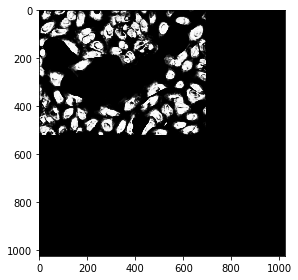

In [36]:
print(X_pred.shape)
imshow(np.squeeze(X_pred[0]))
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


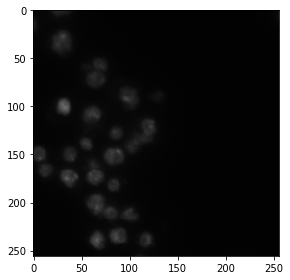

0.99291766
(256, 256)


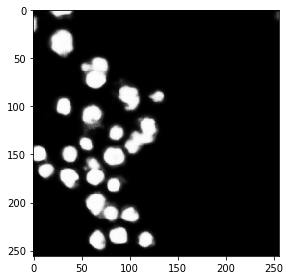

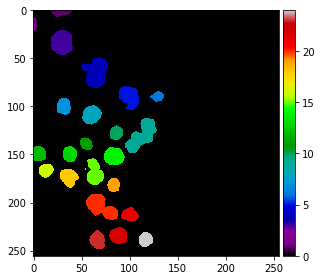

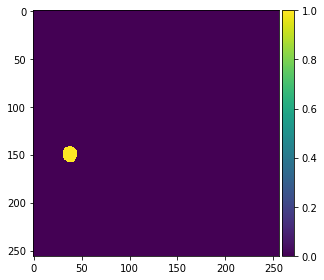

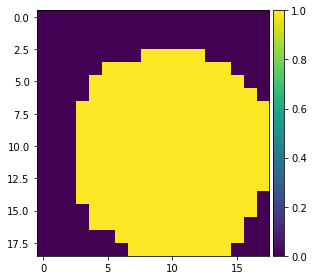

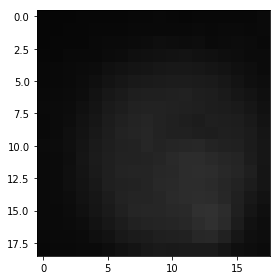

(19, 18, 1)


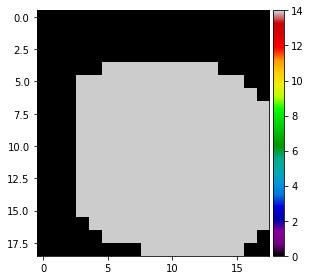

In [12]:
"""
Testing our implementation of localizing masks
"""

ix = 0
img = upsampler(X_train[ix],sizes_train[ix])
imshow(np.array(img[:,:,0:3]))

plt.show()
labs = upsampler(X_pred[ix],sizes_train[ix])
print(np.max(labs))
print(labs.shape)
imshow(np.squeeze(labs))
plt.show()
lab_img = label(labs > 0.5)
imshow(lab_img, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

cnt = lab_img == 13
cnt = cnt*1
imshow(cnt)
plt.show()

i, j = np.where(cnt)

indices = np.meshgrid( np.arange(max(min(i)-3,0), max(i) + 1),
                      np.arange(max(min(j)-3,0), max(j) + 1),
                      indexing='ij')

sub_image = cnt[indices]
imshow(sub_image)
plt.show()

imshow(X_train[ix][indices])
plt.show()


print(Y_new[ix][indices].shape)
imshow(np.squeeze(Y_new[ix][indices]), cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

In [37]:
### Load X_pred ###
IMG_WIDTH_seg = 128
IMG_HEIGHT_seg = 128

In [38]:
X_train_new = []
Y_train_new = []
max_size = np.eye(1).shape
X_train_sizes = []
X_img = []
X_inds = []
"""
Localizing the masks by using the functions created
"""

for ind1 in range(len(X_pred)):
    xboxs1,inds = ytrain_generator_test(upsampler(X_pred[ind1],sizes_train[ind1],IMG_WIDTH,IMG_WIDTH))
    print(len(xboxs1))
    place = 0
    for xbox in xboxs1:
        X_img.append(ind1)

        temp_final = np.ones((IMG_WIDTH_seg,IMG_HEIGHT_seg,2))
        
        tempinds = np.meshgrid( np.arange(inds[place][0], inds[place][1]),
                      np.arange(inds[place][2], inds[place][3]),
                      indexing='ij')
        X_inds.append(inds[place])
        
        temp_img = upsampler(X_train[ind1],sizes_train[ind1],IMG_WIDTH,IMG_WIDTH)[tempinds]
        temp_img = imgreform(temp_img,IMG_HEIGHT_seg,IMG_WIDTH_seg)
        temp_final[:,:,1] = np.sum(temp_img,axis = 2)/3.0
        
        tempx = imgreformY(xbox,IMG_HEIGHT_seg,IMG_WIDTH_seg)
        temp_final[:,:,0] = tempx*255
        X_train_new.append(temp_final)
        X_train_sizes.append(xbox.shape)
        max_size = max(xbox.shape,max_size)
        place += 1
    for ybox in yboxs1:
        tempy = imgreformY(ybox,int(IMG_HEIGHT_seg),int(IMG_WIDTH_seg))
        Y_train_new.append(np.max(tempy))

X_train_new = np.array(X_train_new)
Y_train_new = np.array(Y_train_new)
num = len(Y_train_new)
Y_train_new = np.reshape(Y_train_new,(num,1))
# Y_train_new = np.reshape(Y_train_new,(num,int(IMG_WIDTH_seg),int(IMG_HEIGHT_seg),1))
print(X_train_new.shape)
print(Y_train_new.shape)

166
63
5
181
82
50
64
366
0
68
(1045, 128, 128, 2)
(0, 1)


In [0]:
X_train_new1 =  np.copy(X_train_new)
Y_train_new1 = np.copy(Y_train_new)

In [0]:
X_train_new2 = np.concatenate((X_train_new1,X_train_new),axis = 0)
Y_train_new2 = np.concatenate((Y_train_new1,Y_train_new),axis = 0)
print(X_train_new2.shape)
print(Y_train_new2.shape)

(547, 128, 128, 2)
(547, 1)


In [0]:
X_train_new3 = np.concatenate((X_train_new2,X_train_new),axis = 0)
Y_train_new3 = np.concatenate((Y_train_new2,Y_train_new),axis = 0)
print(X_train_new3.shape)
print(Y_train_new3.shape)

In [33]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_test = np.zeros((10, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
count = 0
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if n < 10:
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = imgreform(img,IMG_HEIGHT, IMG_WIDTH)
        X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 3019/3019 [00:00<00:00, 25246.39it/s]

Done!


In [34]:
X_train = X_test
sizes_train = sizes_test

Let's see if things look all right by drawing some random images and their associated masks.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


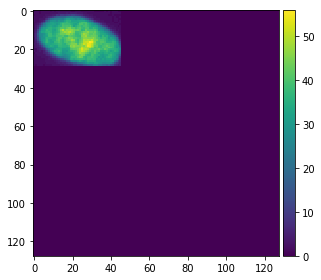

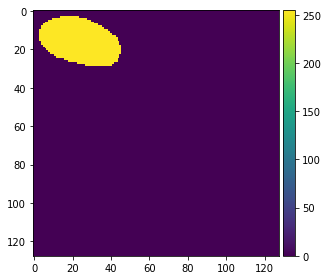

1.0


In [18]:
# Check if training data looks all right
ix = random.randint(0, len(X_train_new))
imshow(X_train_new[ix][:,:,1])
plt.show()
imshow(X_train_new[ix][:,:,0])
plt.show()
print(np.squeeze(Y_train_new[ix]))
# plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

## *Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [25]:
"""
Shuffle the data
"""

from sklearn.utils import shuffle
from skimage import data, feature
X_shuf,y_shuf = shuffle(X_bic2, Y_train_new, random_state=0)
print(X_shuf.shape)
print(y_shuf.shape)

(3627, 13)
(3627, 1)


In [26]:
print(X_bic2.shape)

(3627, 13)


In [0]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=10)
checkpointer = ModelCheckpoint('1000segmenterv7_sequential.h5', verbose=1, save_best_only=True)
results = model2.fit(X_shuf, y_shuf, validation_split=0.1, batch_size=4, epochs=60, 
                    callbacks=[earlystopper, checkpointer])

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [0]:
preds_test_new = model2.predict(X_shuf[-30:], verbose=1)

In [0]:
"""
Sanity check
"""
for i in range(30):
    

    imshow(X_shuf[-i,:,:,0])
    plt.show()

    print(i)
    print(preds_test_new[-i])
    print(y_shuf[-i])


These next two cells will generate the metrics for predicting the number of components

In [39]:
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.mixture import GMM
import cv2
from skimage import color


In [55]:
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy import linalg
from random import random

class EllipsoidTool:
    """Some stuff for playing with ellipsoids"""
    def __init__(self): pass
    
    def getMinVolEllipse(self, P=None, tolerance=0.1):
        """ Find the minimum volume ellipsoid which holds all the points
        
        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!
        
        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]
        
        Returns:
        (center, radii, rotation)
        
        """
        (N, d) = np.shape(P)
        d = float(d)
    
        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)]) 
        QT = Q.T
        
        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse 
        center = np.dot(P.T, u)
    
        # the A matrix for the ellipse
        A = linalg.inv(
                       np.dot(P.T, np.dot(np.diag(u), P)) - 
                       np.array([[a * b for b in center] for a in center])
                       ) / d
                       
        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0/np.sqrt(s)
        
        return (center, radii, rotation)

    def getEllipsoidVolume(self, radii):
        """Calculate the volume of the blob"""
        return np.pi*radii[0]*radii[1]

    def plotEllipsoid(self, center, radii, rotation, ax=None, plotAxes=False, cageColor='b', cageAlpha=0.2):
        """Plot an ellipsoid"""
        make_ax = ax == None
        if make_ax:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
        u = np.linspace(0.0, 2.0 * np.pi, 100)
        v = np.linspace(0.0, np.pi, 100)
        
        # cartesian coordinates that correspond to the spherical angles:
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        # rotate accordingly
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    
        if plotAxes:
            # make some purdy axes
            axes = np.array([[radii[0],0.0,0.0],
                             [0.0,radii[1],0.0],
                             [0.0,0.0,radii[2]]])
            # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)
    
    
            # plot axes
            for p in axes:
                X3 = np.linspace(-p[0], p[0], 100) + center[0]
                Y3 = np.linspace(-p[1], p[1], 100) + center[1]
                Z3 = np.linspace(-p[2], p[2], 100) + center[2]
                ax.plot(X3, Y3, Z3, color=cageColor)
    
        # plot ellipsoid
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)
        
        if make_ax:
            plt.show()
            plt.close(fig)
            del fig

In [56]:
X_bic = []
X_bic2 = []

"""
Creating metrics for the second nueral net to segment the nuclei clusters
"""
ellipse_maker = EllipsoidTool()
for i in range(len(X_train_new)):
    Tester = X_train_new[i][:,:,0]

    X = np.transpose(np.nonzero(Tester))


    if len(X) > 9 :        
        radii = ellipse_maker.getMinVolEllipse(X)
        vol = ellipse_maker.getEllipsoidVolume(radii[1])


        n_components = np.arange(1, 7)
        ### GMM model
        models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)for n in n_components]

        bic = np.array([m.bic(X) for m in models])
        aic = np.array([m.aic(X) for m in models])

        bic = (bic - np.average(bic))/np.std(bic)
        aic = (aic - np.average(aic))/np.std(aic)

        xtemp = np.concatenate((bic,aic),axis = 0)
        
        ### AIC/BIC metric vector 
        xtemp = np.reshape(xtemp,(1,12))
        
        X_bic.append(xtemp)
        
        
        if i%100 ==0 :
            print(i) 
            
    
        ### mask area / ellipse ratio    
        ratio = [np.sum(Tester>0)/vol]

        
        xtemp2 = np.concatenate((bic,aic,ratio),axis = 0)
        xtemp2 = np.reshape(xtemp2,(1,13))
        X_bic2.append(xtemp2)
        
#         plt.legend(loc='best')
#         plt.xlabel('n_components');
#         plt.show()

    elif len(X) <= 9:
        X_bic.append(np.zeros((1,12)))
        X_bic2.append(np.zeros((1,13)))
        
X_bic = np.squeeze(np.array(X_bic))
X_bic2 = np.squeeze(np.array(X_bic2))                     
print(X_bic2.shape)

0
100
200
500
600
700
1000
(1045, 13)


Fully connected neural net with 3 layers to predict the number of components

In [0]:
img = cv2.imread('gradient.png',0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
print(img.shape)

(604, 1566)


In [42]:

"""
Second nueral net to segment the cells
"""

modelB = Sequential()
modelB.add(Dense(30, input_shape=(13,)))
modelB.add(Dense(20, activation='relu'))
modelB.add(Dense(20, activation='relu'))
# modelB.add(Dense(10, activation='relu'))
modelB.add(Dense(1, activation='linear'))

modelB.compile(optimizer='adam',loss='mean_squared_error')
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 30)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 21        
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________


In [46]:
earlystopper = EarlyStopping(patience=20, verbose=10)
checkpointer = ModelCheckpoint('k_pred_v11.h5', verbose=1, save_best_only=True)
results = modelB.fit(X_shuf, y_shuf, validation_split=0.2, batch_size=40, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 2901 samples, validate on 726 samples
Epoch 1/100
2901/2901 [==============================] - 0s 105us/step - loss: 0.4363 - val_loss: 1.3412

Epoch 00001: val_loss improved from inf to 1.34122, saving model to k_pred_v11.h5
Epoch 2/100
2901/2901 [==============================] - 0s 105us/step - loss: 0.4427 - val_loss: 1.3219

Epoch 00002: val_loss improved from 1.34122 to 1.32194, saving model to k_pred_v11.h5
Epoch 3/100
2901/2901 [==============================] - 0s 106us/step - loss: 0.4399 - val_loss: 1.3127

Epoch 00003: val_loss improved from 1.32194 to 1.31272, saving model to k_pred_v11.h5
Epoch 4/100
2901/2901 [==============================] - 0s 106us/step - loss: 0.4489 - val_loss: 1.3500

Epoch 00004: val_loss did not improve
Epoch 5/100
2901/2901 [==============================] - 0s 110us/step - loss: 0.4408 - val_loss: 1.3098

Epoch 00005: val_loss improved from 1.31272 to 1.30981, saving model to k_pred_v11.h5
Epoch 6/100
2901/2901 [======================

In [44]:
modelBV = load_model('k_pred_v11.h5')

In [0]:
preds_test = modelBV.predict(X_bic[-100:])

In [0]:
for i in range(100):
    print(preds_test[-i], 'actual:',Y_train_new[-i])

[0.9275511] actual: [1.]
[0.8955397] actual: [1.]
[0.8022875] actual: [1.]
[0.81162465] actual: [1.]
[0.9405194] actual: [1.]
[1.201247] actual: [1.]
[1.006747] actual: [0.]
[1.118838] actual: [1.]
[0.9754303] actual: [1.]
[1.2686858] actual: [1.]
[0.9103238] actual: [1.]
[1.12029] actual: [1.]
[0.68967265] actual: [1.]
[1.6288022] actual: [2.]
[1.839911] actual: [1.]
[1.71362] actual: [1.]
[1.9195915] actual: [1.]
[1.8250679] actual: [2.]
[1.7791939] actual: [1.]
[1.6718855] actual: [2.]
[1.7330468] actual: [1.]
[1.682438] actual: [1.]
[0.84400016] actual: [1.]
[1.8122274] actual: [1.]
[1.7569138] actual: [1.]
[1.8434271] actual: [1.]
[1.7223165] actual: [2.]
[1.7478552] actual: [1.]
[1.6956623] actual: [2.]
[1.7342061] actual: [1.]
[1.8101655] actual: [1.]
[1.7282616] actual: [1.]
[1.8240027] actual: [1.]
[1.807043] actual: [1.]
[1.8223115] actual: [1.]
[1.6453105] actual: [1.]
[1.3458796] actual: [1.]
[1.5650079] actual: [1.]
[1.3075317] actual: [1.]
[1.3699303] actual: [1.]
[1.3306

This next cell will predict on the 12 parameters passed in by each box's GMM lines and generate the new labels based on the prediction. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


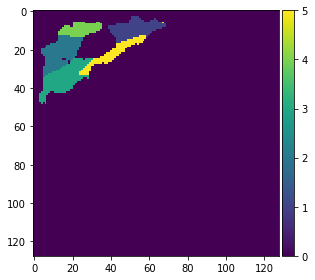

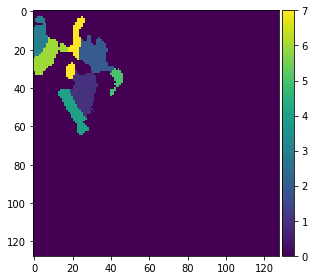

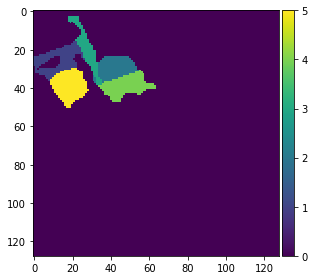

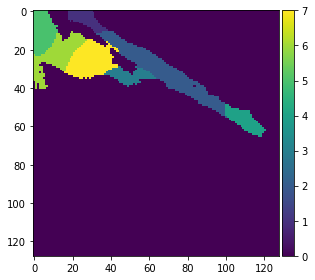

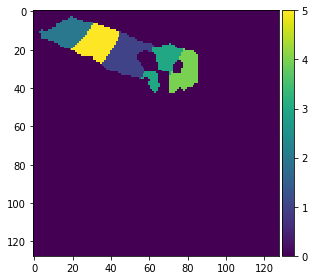

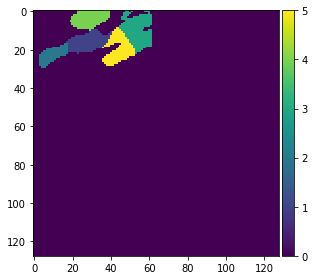

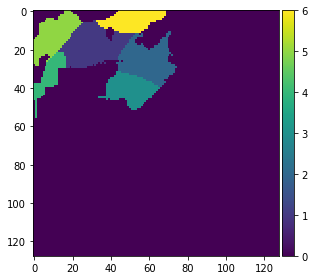

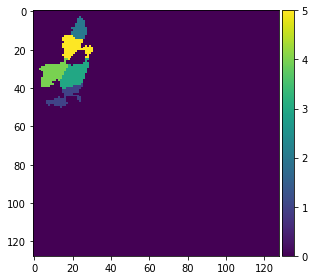

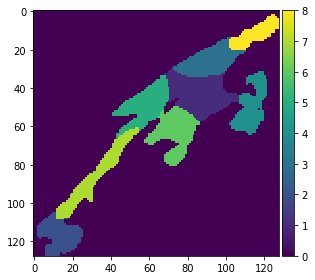

1039
0


In [59]:
"""
Preminary test on how our segmentor perform
"""

X_pred_bic = modelBV.predict(X_bic2)
X_new_boxs = np.zeros_like(X_train_new[:,:,:,0])
count = 0 
count1 = 0 
for i in range(len(X_train_new)):
    Tester = X_train_new[i][:,:,0]
    
    X = np.transpose(np.nonzero(Tester))

    Test_re = np.copy(Tester)/255
    ### number of components predicted
    n_comp = int(np.round(X_pred_bic[i]))

    if n_comp == 0:
        n_comp = 1
    
    if n_comp >= 1:
        gmm = mixture.GaussianMixture(n_components = n_comp, covariance_type='full').fit(X)
        labels2 =  gmm.predict(X) + 1
        count += 1

        Test_re[X[:,0],X[:,1]] = labels2

    X_new_boxs[i] = Test_re
    if np.max(X_new_boxs[i]) >= 5:
        imshow(Test_re)
        plt.show()
        
print(count)
print(count1)
# print('Accuracy of predicting number of components: ',float(count)/600.0) #len(X_pred_bic))
# print('Accuracy of saying each thing is 1: ',float(count1)/600.0) #len(X_pred_bic))

In [49]:
print(X_new_boxs.shape)

(1045, 128, 128)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


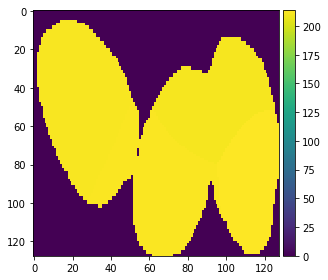

(68, 135)
(68, 135)


In [89]:
imshow(X_new_boxs[348])
plt.show()
print(X_train_sizes[348])

a = upsampler(X_new_boxs[348],X_train_sizes[348],IMG_HEIGHT_seg,IMG_WIDTH_seg)

print(a.shape)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


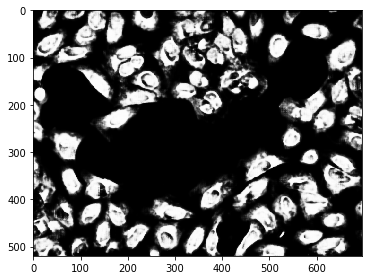

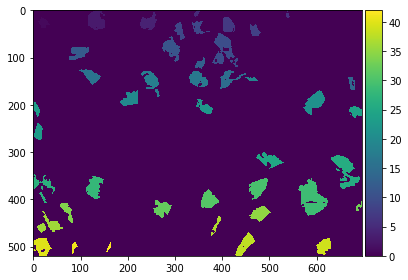

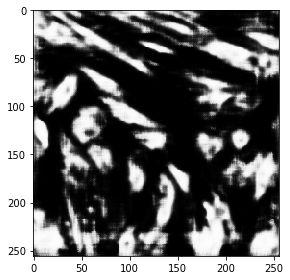

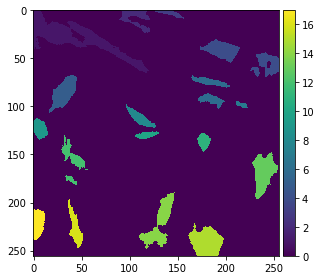

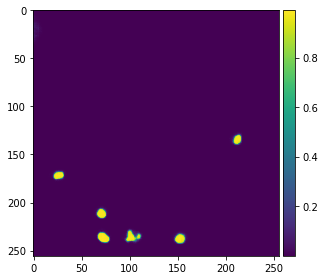

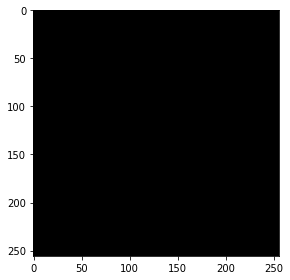

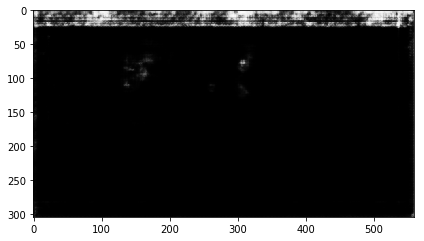

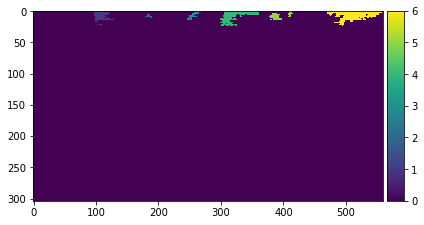

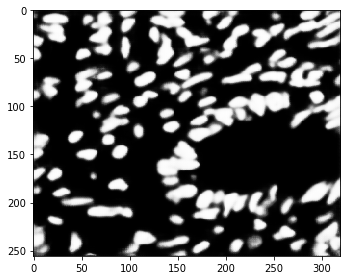

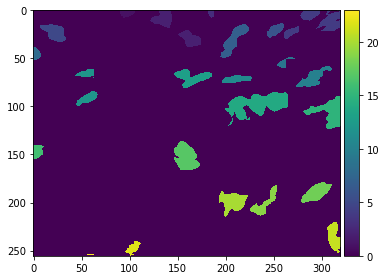

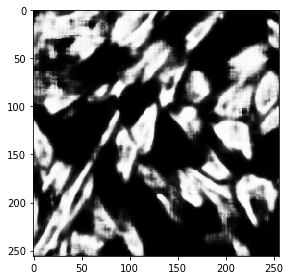

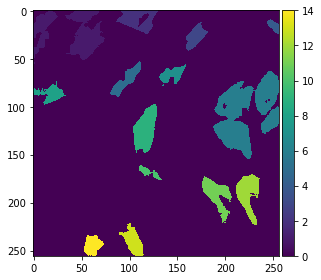

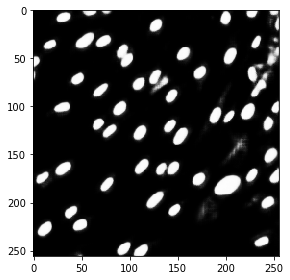

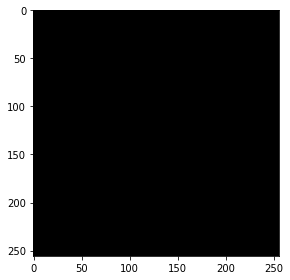

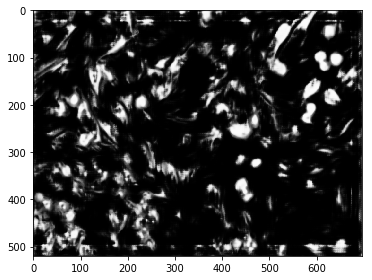

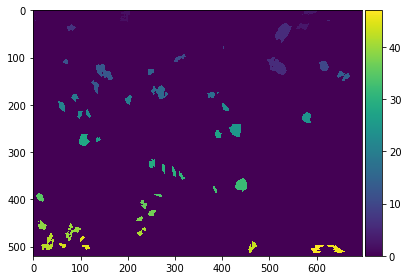

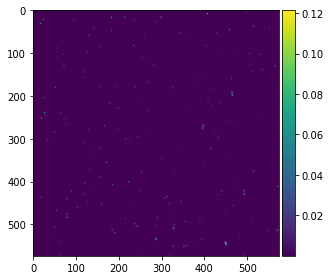

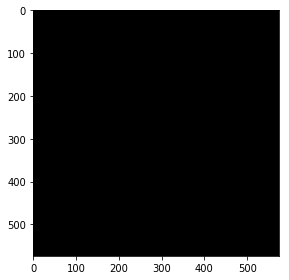

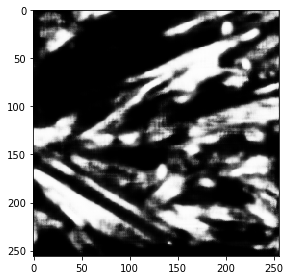

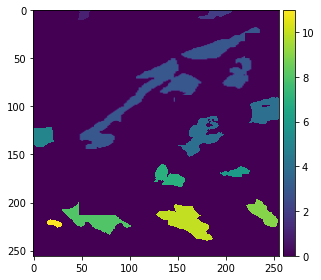

In [61]:
X_pred_final_unresized = np.zeros_like(X_pred)

"""
Final model evaluation
"""

for i in range(len(X_new_boxs)):
#     print(i)
    inds = X_inds[i]
    tempinds = np.meshgrid( np.arange(inds[0], inds[1]),
                      np.arange(inds[2], inds[3]),
                      indexing='ij')
    
    box = (X_new_boxs[i]>1)*1.0

    origin = X_img[i]
    current_max = np.max(X_pred_final_unresized[origin])
    
    temp_box = box
    temp_box[np.where(temp_box >= 1)] += current_max

    resized_box = upsampler(temp_box,X_train_sizes[i],IMG_HEIGHT_seg,IMG_WIDTH_seg)
    shapebox = resized_box.shape
    if len(shapebox) == 1:
        continue
    resized_box = np.resize(resized_box,(shapebox[0],shapebox[1],1))
    
    X_pred_final_unresized[origin][tempinds] = resized_box

for i in range(len(X_pred)):
    imshow(upsampler(np.squeeze(X_pred[i]),sizes_train[i],IMG_WIDTH,IMG_HEIGHT))
    plt.show()

    imshow(upsampler(np.squeeze(X_pred_final_unresized[i]),sizes_train[i],IMG_WIDTH,IMG_HEIGHT))
    plt.show()



# ix = random.randint(0, len(test_ids))
ix = 4

upimg = upsampler(X_test[ix],sizes_test[ix])
print(sizes_test[ix])
print(upimg.shape)
imshow(upimg)
plt.show()

In [0]:
model = load_model('3model-padded-dsbowl2018.h5', custom_objects={'mean_iou': mean_iou})

In [0]:
batch = [60,66]

In [0]:
# Predict on train, val and test

# a = model.predict(X_test[0:3],verbose = 1)

# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
        
preds_test = model.predict(X_test[batch[0]:batch[1]], verbose=1)

# # Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)

# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# # Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(upsampler(preds_test[i],sizes_test[i+batch[0]]))

In [0]:
#### Perform a sanity check on some random training samples
# ix = random.randint(0, len(preds_train_t))
for i in range(5):
    ins = i
    imshow(X_test[ins+batch[0]][:sizes_test[ins+batch[0]][0],:sizes_test[ins+batch[0]][1]])
    plt.show()
    # imshow(np.squeeze(Y_train[ix]))
    # plt.show()
    print(sizes_test[ins+batch[0]])
    
    print(preds_test_upsampled[ins].shape)
    imshow(np.squeeze(preds_test_upsampled[ins]))
    plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        if sum(lab_img == i) > 4:
            yield rle_encoding(lab_img == i)

In [0]:
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [0]:
ind1 = 1

In [0]:
ActualIMG = X_test[batch[0]+ind1]
imshow(upsampler(X_test[batch[0]+ind1],sizes_test[batch[0]+ind1]))
plt.show()
Testing = preds_test_upsampled[ind1]
imshow(Testing)
plt.show()
lab_img = label(Testing > 0.5)
imshow(lab_img, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()
# for i in range(1, lab_img.max() + 1):
#         imshow(i == lab_img)
#         plt.show()

In [0]:
cnt = lab_img == 3
cnt = cnt*1
imshow(cnt)
plt.show()

i, j = np.where(cnt)
indices = np.meshgrid(np.arange(min(i), max(i) + 1),
                      np.arange(min(j), max(j) + 1),
                      indexing='ij')
sub_image = cnt[indices]
imshow(sub_image)
plt.show()

imshow(X_test[batch[0]+ind1][indices])
plt.show()

In [0]:
ActualIMG = X_test[batch[0]+ind1]
imshow(upsampler(X_test[batch[0]+ind1],sizes_test[batch[0]+ind1]))
plt.show()
Testing = preds_test_upsampled[ind1]
imshow(Testing)
plt.show()
Testing = preds_test_upsampled[ind1] > 0.5
distance = ndi.distance_transform_edt(Testing)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=Testing)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=Testing)

imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()
print(labels.shape)


Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    if n >= batch[0] and n < batch[1]:
        rle = list(prob_to_rles(preds_test_upsampled[n-batch[0]]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('2-dsbowl-sub-60-66.csv', index=False)

This will create a submission in the form of many files to be combined later.

In [0]:
model = load_model('Newsubmission.h5', custom_objects={'mean_iou': mean_iou})
batches = ([0,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,66])

for batch in batches:
    preds_test = model.predict(X_test[batch[0]:batch[1]], verbose=1)
    preds_test_upsampled = []
    
    for i in range(len(preds_test)):
        preds_test_upsampled.append(upsampler(preds_test[i],sizes_test[i+batch[0]]))
    new_test_ids = []
    rles = []
    
    for n, id_ in enumerate(test_ids):
        if n >= batch[0] and n < batch[1]:
            rle = list(prob_to_rles(preds_test_upsampled[n-batch[0]]))
            rles.extend(rle)
            new_test_ids.extend([id_] * len(rle))
            
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    batchstr = str(batch[0])
    filename = 'dsbowl.csv'
    sub.to_csv(batchstr+filename, index=False)